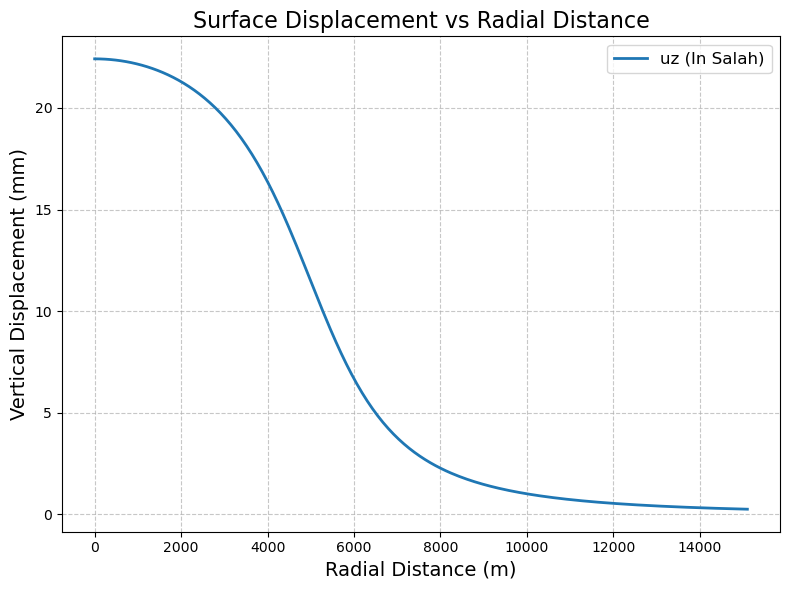

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import j0, j1



def integrand(alpha, r, d, R):
    return np.exp(-alpha * d) * j1(alpha * R) * j0(alpha * r)

def uz_formula_corrected(r, Cm, h, dp_res, v, R, d):
    integral_value, _ = quad(integrand, 0, np.inf, args=(r, d, R), epsabs=1e-10, epsrel=1e-10)
    uz = 2 * Cm * (1 - v) * h * dp_res * R * integral_value
    return uz * 1000  # displacement in mm

# In Salah Field 
in_salah_data = {
    "h": 20,  # Layer thickness in meters
    "R": 5100,  # Reservoir radius in meters
    "v": 0.2,  # Poisson's ratio
    "E": 6e9,  # Young's modulus in Pascals
    "dp_res": 7e6,  # Pressure change in Pascals
    "d": 1800  # Depth in meters
}

alpha_B = 1  # Biot coefficient
v = in_salah_data["v"]
E = in_salah_data["E"]
Cm = alpha_B * ((1 + v) * (1 - 2 * v)) / ((1 - v) * E)
h = in_salah_data["h"]
dp_res = in_salah_data["dp_res"]
d = in_salah_data["d"]
R = in_salah_data["R"]

# r_values
r_values = np.linspace(0, 15100, 250)
uz_values_adjusted = [uz_formula_corrected(r, Cm, h, dp_res, v, R, d) for r in r_values]

# 第urface displacement vs radial distance 
plt.figure(figsize=(8, 6))
plt.plot(r_values, uz_values_adjusted, label=f"uz (In Salah)", linewidth=2)
plt.title("Surface Displacement vs Radial Distance", fontsize=16)
plt.xlabel("Radial Distance (m)", fontsize=14)
plt.ylabel("Vertical Displacement (mm)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


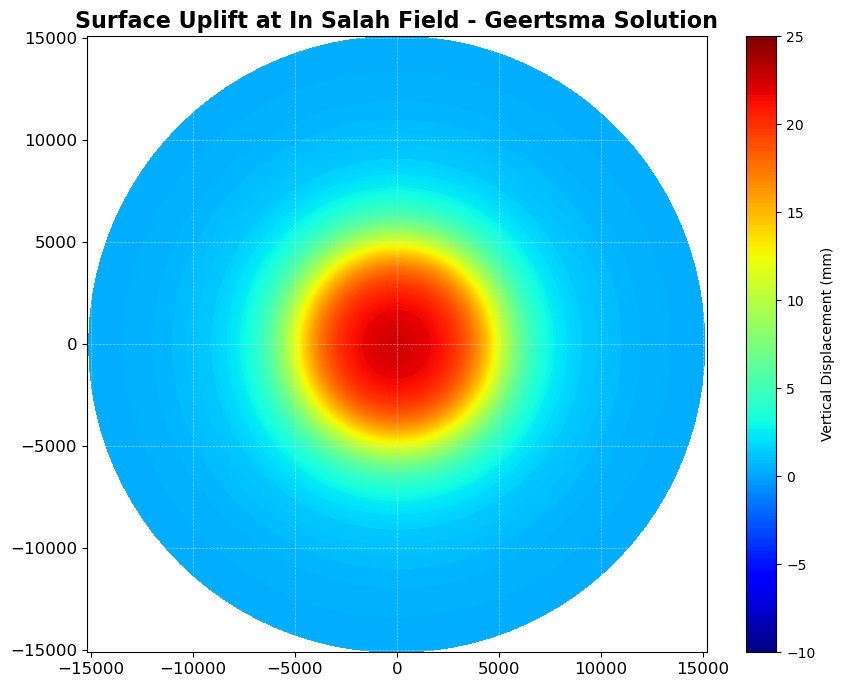

In [2]:
# Hear map of surface uplift 
theta_values = np.linspace(0, 2 * np.pi, 100)
r_grid, theta_grid = np.meshgrid(r_values, theta_values)
x_grid = r_grid * np.cos(theta_grid)
y_grid = r_grid * np.sin(theta_grid)


uz_grid = np.array([[uz_formula_corrected(r, Cm, h, dp_res, v, R, d) for r in row] for row in r_grid])

plt.figure(figsize=(10, 8))
contour = plt.contourf(x_grid, y_grid, uz_grid, levels=np.linspace(-10, 25, 200), cmap='jet', vmin=-10, vmax=25, extend='neither')
cbar = plt.colorbar(contour, label="Vertical Displacement (mm)")
cbar.set_ticks(np.linspace(-10, 25, 8))

plt.title("Surface Uplift at In Salah Field - Geertsma Solution", fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis('equal')
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()


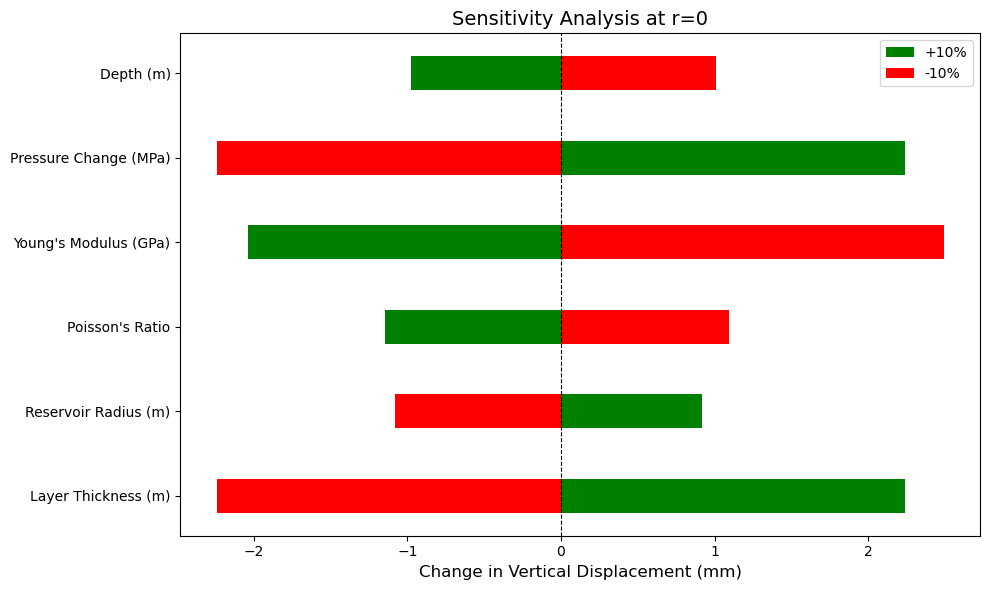

In [3]:

sensitivity_results = {}


for param, base_value in in_salah_data.items():
    if param == "v":
        values = np.linspace(max(0, base_value * 0.9), min(0.5, base_value * 1.1), 3)
    else:
        values = np.linspace(base_value * 0.9, base_value * 1.1, 3)

    uz_values = []
    for value in values:
        modified_data = in_salah_data.copy()
        modified_data[param] = value
        v = modified_data["v"]
        E = modified_data["E"]
        Cm = alpha_B * ((1 + v) * (1 - 2 * v)) / ((1 - v) * E)  # Calculate Cm for each variation
        uz = uz_formula_corrected(0, Cm, modified_data["h"], modified_data["dp_res"], v, modified_data["R"], modified_data["d"])
        uz_values.append(uz)

    sensitivity_results[param] = (values, uz_values)


base_uz = uz_formula_corrected(
    0, 
    alpha_B * ((1 + in_salah_data["v"]) * (1 - 2 * in_salah_data["v"])) / ((1 - in_salah_data["v"]) * in_salah_data["E"]),
    in_salah_data["h"], 
    in_salah_data["dp_res"], 
    in_salah_data["v"], 
    in_salah_data["R"], 
    in_salah_data["d"]
)


fig, ax = plt.subplots(figsize=(10, 6))
param_labels = {
    "h": "Layer Thickness (m)",
    "dp_res": "Pressure Change (MPa)",
    "E": "Young's Modulus (GPa)",
    "v": "Poisson's Ratio",
    "R": "Reservoir Radius (m)",
    "d": "Depth (m)"
}

y_positions = np.arange(len(sensitivity_results))
bar_width = 0.4  


for i, (param, (values, uz_values)) in enumerate(sensitivity_results.items()):
    deltas = np.array(uz_values) - base_uz  
    low, high = deltas[0], deltas[-1]  

    ax.barh(y_positions[i], high, bar_width, color='green', label=f"+10%" if i == 0 else "")
    ax.barh(y_positions[i], low, bar_width, color='red', label=f"-10%" if i == 0 else "")

ax.set_yticks(y_positions)
ax.set_yticklabels([param_labels[param] for param in sensitivity_results.keys()], fontsize=10)
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_xlabel("Change in Vertical Displacement (mm)", fontsize=12)
ax.set_title("Sensitivity Analysis at r=0", fontsize=14)
ax.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()
